In [1]:
%autosave 20

import os
import sys
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D
from keras.layers import MaxPool2D
from keras.layers import UpSampling2D
from keras.layers import Concatenate
from google.colab import drive
import cv2

Autosaving every 20 seconds


In [2]:
drive.mount('/content/drive/')
dataset_folder = 'drive/MyDrive/datasets/EndoTect_2020_Segmentation_Test_Dataset'

def load_data(folder):
  imgs = []
  msks = []

  for fname in os.listdir(folder + "/images"):
    img = cv2.imread(os.path.join(folder + "/images", fname))
    msk = cv2.imread(os.path.join(folder + "/masks", fname[:-3] + "png"), 0)

    if img is not None and msk is not None:
      imgs.append(img)
      msks.append(msk)


  return [imgs, msks]

Mounted at /content/drive/


In [3]:
images, masks = load_data(dataset_folder)

print(len(images), len(masks))

200 200


In [4]:
for i in range(len(images)):
  images[i] = cv2.resize(images[i], (128,128))
  masks[i] = cv2.resize(masks[i], (128,128))
  mask_ = []
  for j in range(128):
    mask_row = []
    for k in range(128):
      mask_row.append([masks[i][j,k]])
    mask_.append(mask_row)
  mask__ = np.array(mask_)
  masks[i] = mask__

In [5]:
def down_conv(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)
  pool = MaxPool2D((2,2), (2,2))(conv)

  return [conv, pool]

def up_conv(prev_layer, skip_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  upsamp = UpSampling2D((2,2))(prev_layer)
  conc = Concatenate()([upsamp, skip_layer])
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conc)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def bootle_neck(prev_layer, num_layers,  kernel_size=(3,3), padding="same", strides=1, activation="relu"):
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(prev_layer)
  conv = Conv2D(num_layers, kernel_size, padding=padding, strides=strides, activation=activation)(conv)

  return conv

def reduce_layers(layer):
  return Conv2D(1, (1,1), padding="same", activation="sigmoid")(layer)

In [6]:
input = keras.layers.Input((128,128,3))
conv1, pool1 = down_conv(input, 16)
conv2, pool2 = down_conv(pool1, 32)
conv3, pool3 = down_conv(pool2, 64)
conv4, pool4 = down_conv(pool3, 128)

bneck = bootle_neck(pool4, 256)

up1 = up_conv(bneck, conv4, 128)
up2 = up_conv(up1, conv3, 64)
up3 = up_conv(up2, conv2, 32)
up4 = up_conv(up3, conv1, 16)

output = reduce_layers(up4)

model = keras.models.Model(input, output)

opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 64, 16)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

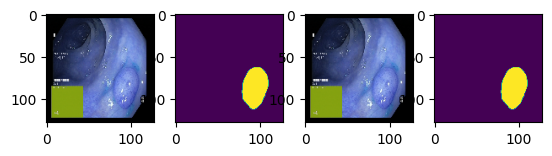

In [7]:
plt.subplot(141)
plt.imshow(images[0])
plt.subplot(142)
plt.imshow(masks[0])

images = np.array(images)
masks = np.array(masks)
images = images/255.
masks = masks/255.

plt.subplot(143)
plt.imshow(images[0])
plt.subplot(144)
plt.imshow(masks[0])

plt.show()


In [8]:
model.fit(images, masks, epochs=150, validation_split=0.2)

Epoch 1/150
5/5 [==============================] - 19s 305ms/step - loss: 0.8611 - accuracy: 0.6377 - val_loss: 0.6431 - val_accuracy: 0.8447
Epoch 2/150
5/5 [==============================] - 0s 82ms/step - loss: 0.6538 - accuracy: 0.8562 - val_loss: 0.6376 - val_accuracy: 0.8447
Epoch 3/150
5/5 [==============================] - 0s 83ms/step - loss: 0.5655 - accuracy: 0.8562 - val_loss: 0.5138 - val_accuracy: 0.8447
Epoch 4/150
5/5 [==============================] - 0s 90ms/step - loss: 0.4607 - accuracy: 0.8562 - val_loss: 0.4677 - val_accuracy: 0.8447
Epoch 5/150
5/5 [==============================] - 0s 90ms/step - loss: 0.3977 - accuracy: 0.8562 - val_loss: 0.3701 - val_accuracy: 0.8447
Epoch 6/150
5/5 [==============================] - 0s 95ms/step - loss: 0.3460 - accuracy: 0.8562 - val_loss: 0.3585 - val_accuracy: 0.8447
Epoch 7/150
5/5 [==============================] - 0s 85ms/step - loss: 0.3353 - accuracy: 0.8562 - val_loss: 0.3343 - val_accuracy: 0.8447
Epoch 8/150
5/5 [=

1/1 [==============================] - 0s 91ms/step


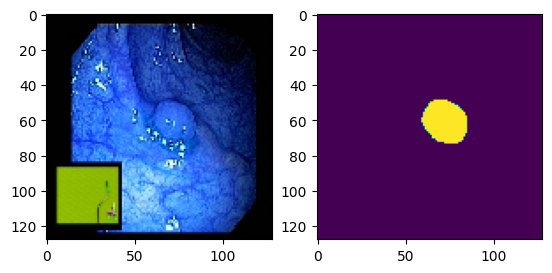

In [11]:
x = images[101]

ans = model.predict(np.array([x]))

ans = ans[0] > 0.5

plt.subplot(121)
plt.imshow(x)

plt.subplot(122)
plt.imshow(ans)

plt.show()